In [83]:
import geopandas as gpd
import pandas as pd

### Data Sources
- [Census County Shapefiles w/ Geometry](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2024&layergroup=Counties+%28and+equivalent%29)
- [Census County Population](https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html)

In [180]:
gdf = gpd.read_file("data/tl_2024_us_county/tl_2024_us_county.shp")
pop_df = pd.read_csv("data/co-est2024-alldata.csv", encoding = "ISO-8859-1")

In [181]:
pop_df['STATE'] = pop_df['STATE'].astype(str).str.zfill(2)
gdf_pop = gdf.merge(pop_df[['STATE','CTYNAME','POPESTIMATE2024']], how='left', left_on=['STATEFP', 'NAMELSAD'], right_on=['STATE','CTYNAME'])
gdf_pop = gdf_pop.drop_duplicates()

In [183]:
print(len(gdf_pop))
print(len(gdf_pop['GEOID'].unique()))

3235
3235


In [184]:
gdf_pop.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,STATE,CTYNAME,POPESTIMATE2024
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,...,None,A,1477563042,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55525 41.82892, -96.55524 41.827...",31,Cuming County,8952.0
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,...,None,A,680980773,61564428,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.2645, -123.72756 46.26...",53,Wahkiakum County,4800.0


<Axes: >

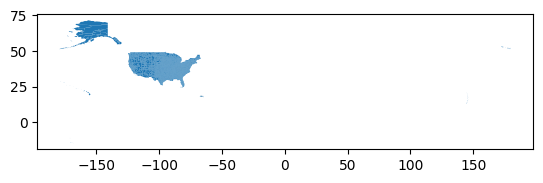

In [185]:
gdf_pop.plot()

### Clip to CONUS

In [187]:
from shapely.wkt import loads

# CONUS boundary simplified WKT
conus_wkt = """POLYGON((-124.848974 24.396308,-66.885444 24.396308,
                        -66.885444 49.384358,-124.848974 49.384358,
                        -124.848974 24.396308))"""
conus_geometry = loads(conus_wkt)
gdf_conus = gdf_pop[gdf_pop.geometry.intersects(conus_geometry)]

<Axes: >

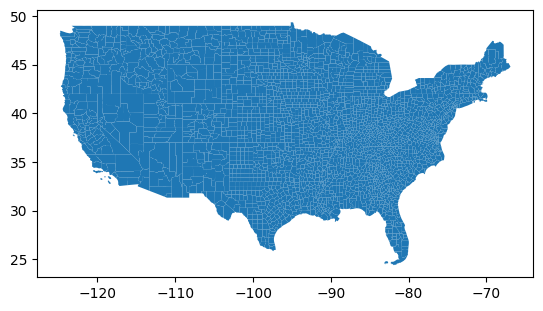

In [188]:
gdf_conus.plot()

### Save shapefile and upload to S3

In [99]:
gdf_conus.to_file("data/tl_2024_us_county/tl_2024_us_county_pop_conus.shp")

/var/folders/7r/sqrdbgxx6n7_gwgbkd8fxqrc0000gq/T/ipykernel_52900/647995259.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_conus.to_file("data/tl_2024_us_county/tl_2024_us_county_pop_conus.shp")
/Users/madiejf/miniconda3/envs/geoenv/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'POPESTIMATE2024' to 'POPESTIMAT'
  ogr_write(


In [120]:
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, LogNorm
import numpy as np

In [189]:
def plot_function(gdf, column, title):
    gdf_web = gdf.to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # calculate custom breaks
    min_val = gdf_web[column].min()
    max_val = gdf_web[column].max()
    breaks = [min_val,
              np.percentile(gdf_web[column], 25),
              np.percentile(gdf_web[column], 40),
              np.percentile(gdf_web[column], 75),
              np.percentile(gdf_web[column], 95),
              np.percentile(gdf_web[column], 97.5),
              max_val]
    
    # plot choropleth
    gdf_web.plot(column=column,
                 ax=ax,
                 legend=True,
                 legend_kwds={'title': title, 'loc': 'lower right'},
                 cmap='YlOrRd',
                 scheme='user_defined',
                 classification_kwds={'bins': breaks})
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    plt.title(title)

    return

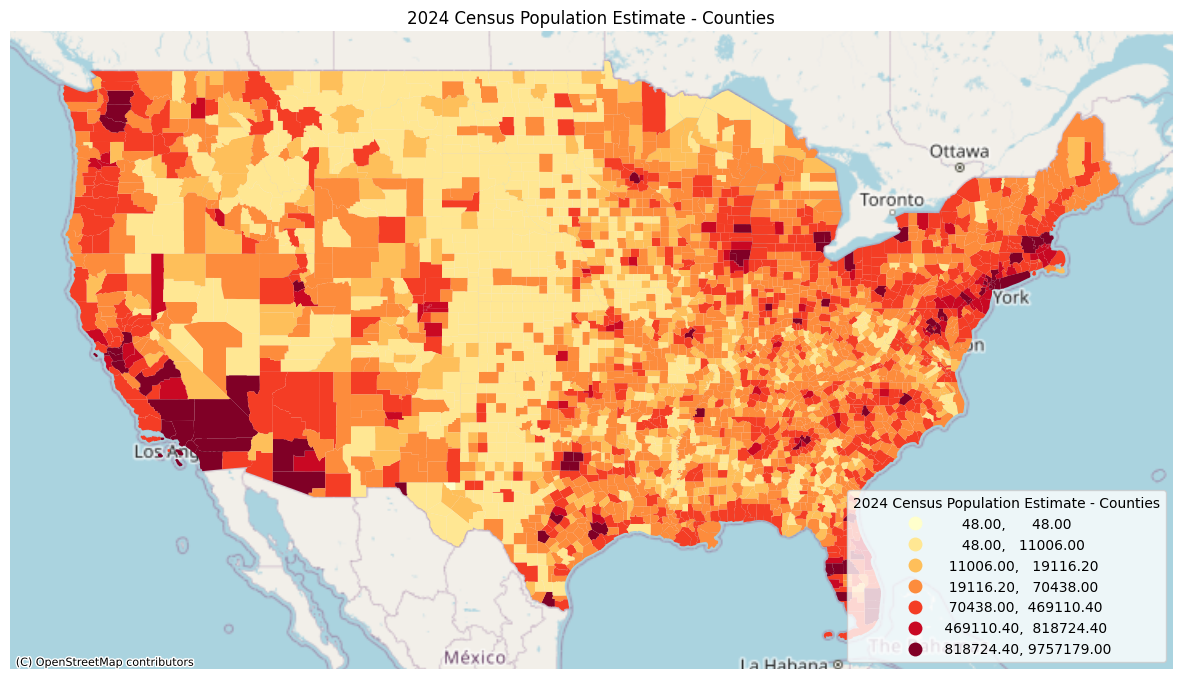

In [191]:
plot_function(gdf_conus, 'POPESTIMATE2024', '2024 Census Population Estimate - Counties')

### Now, plot the results after running the H3-Indexer on the data

Example yaml config for the H3-Indexer:
```
name: "county_pop_example"
version: "1.0.0"
h3_resolution: 4
output_s3_path: 'wws-air-quality/h3-indexer-outputs'
inputs:
  county_pop:  
    type: "vector"
    s3_path: "wws-air-quality/census/tl_2024_us_county/tl_2024_us_county_pop_conus.shp"
    unique_id: "GEOID"
    geometry_type: "POLYGON"
    geometry_column_name: "geometry"
    method: "PCT_AREA"
    input_columns:
      - "POPESTIMAT"
```

In [200]:
path = 'data/tl_2024_us_county/resolver_output'
dataset = ds.dataset(path, format="parquet")
h3_df = dataset.to_table().to_pandas()

In [201]:
import h3
from shapely.geometry import Polygon

def h3_to_geom(h3_index):
    coords = h3.cell_to_boundary(h3_index)
    boundary = [[coord[1], coord[0]] for coord in coords]
    boundary.append(boundary[0])  # Close the polygon
    polygon = Polygon(boundary)
    return polygon.wkt

In [202]:
h3_df['wkt_column'] = h3_df['h3_index'].apply(h3_to_wkt)
h3_df['geometry'] = gpd.GeoSeries.from_wkt(h3_df['wkt_column'])
gdf_h3 = gpd.GeoDataFrame(h3_df, geometry='geometry').drop('wkt_column', axis=1)
gdf_h3 = gdf_h3.set_crs(epsg=4326)
gdf_h3.head(2)

,h3_index,h3_area_km2,sum_POPESTIMAT,geometry
0,8412c87ffffffff,1656.520601,48.563249,"POLYGON ((-113.74631 49.40961, -113.97755 49.2..."
1,8412c95ffffffff,1669.498773,1567.855674,"POLYGON ((-112.72637 49.20722, -112.96215 49.0..."


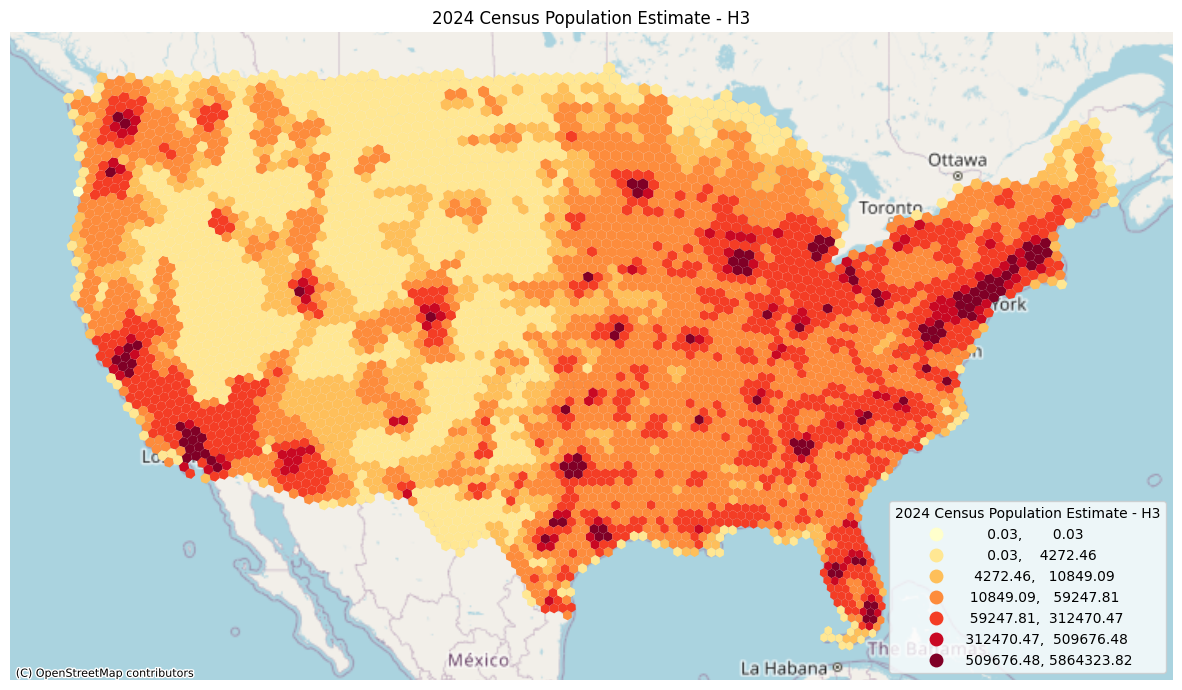

In [203]:
plot_function(gdf_h3, 'sum_POPESTIMAT', '2024 Census Population Estimate - H3')